# Adam vs CPropAdam on Cifar10

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from apex import amp, optimizers
from apex.amp import amp as _amp

In [2]:
from cprop import *

In [3]:
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import *

In [4]:
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize([0.50707516, 0.48654887, 0.44091784],
              [0.26733429, 0.25643846, 0.27615047])
])

test_transform = Compose([
    ToTensor(),
    Normalize([0.50707516, 0.48654887, 0.44091784],
              [0.26733429, 0.25643846, 0.27615047])
])

In [5]:
train_dataset = CIFAR10('./dataset', train=True, download=True, transform=transform)

Files already downloaded and verified


In [6]:
test_dataset = CIFAR10('./dataset', train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [7]:
from torch.utils.data import DataLoader, TensorDataset

In [8]:
def make_model():
    net = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1024, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )
    return net

In [9]:
def accuracy(y_hat, y):
    assert y_hat.dim() == 2
    return (torch.argmax(y_hat, dim=1) == y).float().mean()

In [10]:
def step(net, x, y):
    x = x.to(device)
    y = y.to(device)
    pred = net(x)
    loss = F.cross_entropy(pred, y)
    acc = accuracy(pred, y)
    return loss, acc


@torch.no_grad()
def eval(net, loader):
    n = 0
    avg_loss = 0
    avg_acc = 0
    for x, y in loader:
        loss, acc = step(net, x, y)
        n += len(x)
        avg_loss += len(x) / n * (loss.item() - avg_loss)
        avg_acc += len(x) / n * (acc.item() - avg_acc)
    return avg_loss, avg_acc


def run(n_max_itr,
        lr,
        use_cprob,
        bs=32,
        n_eval_cycle=1000,
        apex=False,
        opt_level='O0',
        # allow to use with O3
        eps=1e-4):
    train_loader = DataLoader(train_dataset, batch_size=bs)
    test_loader = DataLoader(test_dataset, batch_size=bs)
    net = make_model().to(device)

    if use_cprob:
        opt = CPropAdam(net.parameters(),
                        lr,
                        eps=eps,
                        cprop_c=1,
                        cprop_cdf='bft',
                        cprop_eps=eps)
    else:
        opt = optim.Adam(net.parameters(), lr, eps=eps)

    if apex:
        net, opt = amp.initialize(net, opt, opt_level=opt_level)

    train_stats = defaultdict(list)
    test_stats = defaultdict(list)
    i_itr = 1
    with tqdm(total=n_max_itr) as p:
        while i_itr <= n_max_itr:
            for x, y in train_loader:
                loss, acc = step(net, x, y)

                opt.zero_grad()
                
                if apex:
                    with amp.scale_loss(loss, opt) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()
                    
                opt.step()

                train_stats['i_itr'].append(i_itr)
                train_stats['loss'].append(loss.item())
                train_stats['acc'].append(acc.item())
                p.set_postfix({
                    'loss': np.array(train_stats['loss'][-30:]).mean(),
                    'acc': np.array(train_stats['acc'][-30:]).mean(),
                })

                if i_itr % n_eval_cycle == 0:
                    loss, acc = eval(net, test_loader)
                    test_stats['i_itr'].append(i_itr)
                    test_stats['test_loss'].append(loss)
                    test_stats['test_acc'].append(acc)

                i_itr += 1
                p.update()
                if i_itr > n_max_itr:
                    break
                    
    if apex:
        # with O1 optimization, apex patches torch functions leaving permanent trace for subsequent runs
        # this to undo and recover the unpatched torch functions
        if _amp._DECORATOR_HANDLE is not None:
            _amp._DECORATOR_HANDLE._deactivate()

    train_stats = pd.DataFrame(train_stats)
    test_stats = pd.DataFrame(test_stats)
    stats = pd.merge(train_stats, test_stats, 'outer')
    return stats


In [11]:
def plot(df, key, smooth=None, **kwargs):
    df = df[df[key].notna()]
    if smooth:
        df[key] = df[key].rolling(smooth).mean()
    df.plot('i_itr', key, **kwargs)

In [12]:
device = 'cuda'
df = {}

## Comparing many optimization levels

In [16]:
df['adam1e-3O0'] = run(5000, 1e-3, use_cprob=False, apex=True, opt_level='O0')

  0%|          | 21/5000 [00:00<00:43, 114.23it/s, loss=2.28, acc=0.121]

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


100%|██████████| 5000/5000 [00:51<00:00, 97.00it/s, loss=1, acc=0.642]     


In [15]:
df['adam1e-3O1'] = run(5000, 1e-3, use_cprob=False, apex=True, opt_level='O1')

  0%|          | 16/5000 [00:00<00:56, 87.75it/s, loss=2.29, acc=0.129]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


  2%|▏         | 76/5000 [00:00<00:56, 87.69it/s, loss=2.14, acc=0.191]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  8%|▊         | 415/5000 [00:04<00:51, 88.63it/s, loss=1.7, acc=0.352] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 75%|███████▌  | 3764/5000 [00:48<00:14, 87.80it/s, loss=1.11, acc=0.599]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 5000/5000 [01:06<00:00, 75.68it/s, loss=1.03, acc=0.644] 


In [14]:
df['adam1e-3O2'] = run(5000, 1e-3, use_cprob=False, apex=True, opt_level='O2')

  0%|          | 19/5000 [00:00<00:48, 103.27it/s, loss=2.26, acc=0.141]

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  8%|▊         | 381/5000 [00:03<00:45, 102.55it/s, loss=1.64, acc=0.374]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 48%|████▊     | 2412/5000 [00:26<00:25, 100.77it/s, loss=1.25, acc=0.553]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 88%|████████▊ | 4422/5000 [00:48<00:05, 102.70it/s, loss=1.07, acc=0.647] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 5000/5000 [00:56<00:00, 89.14it/s, loss=1.03, acc=0.622]  


In [13]:
df['adam1e-3O3'] = run(5000, 1e-3, use_cprob=False, apex=True, opt_level='O3')

  0%|          | 5/5000 [00:00<12:06,  6.88it/s, loss=2.6, acc=0.115] 

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


100%|██████████| 5000/5000 [00:51<00:00, 96.77it/s, loss=1.12, acc=0.595] 


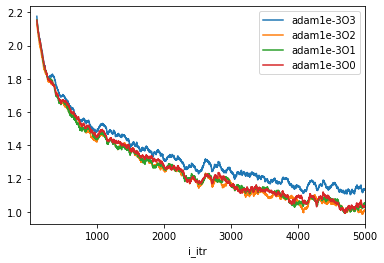

In [17]:
ax = plt.subplot()
for k, v in df.items():
    plot(v, 'loss', smooth=100, ax=ax, label=k)

# Adam vs CPropAdam

In [16]:
dfs2 = {}

### FP32

In [26]:
dfs2['adam'] = run(15000, 1e-3, use_cprob=False, apex=False)

100%|██████████| 15000/15000 [02:35<00:00, 96.62it/s, loss=0.755, acc=0.746] 


In [27]:
dfs2['cprop'] = run(15000, 1e-3, use_cprob=True, apex=False)

100%|██████████| 15000/15000 [02:45<00:00, 90.67it/s, loss=0.598, acc=0.789] 


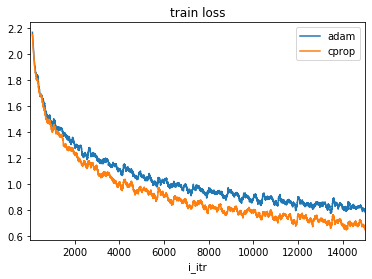

In [29]:
ax = plt.subplot()
ax.set_title('train loss')
for k, v in dfs2.items():
    if k in ['adam', 'cprop']:
        plot(v, 'loss', smooth=100, ax=ax, label=k)

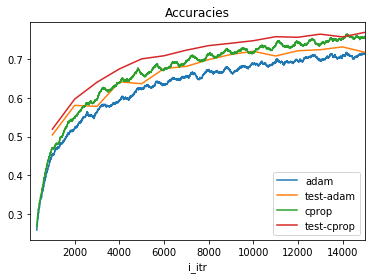

In [ ]:
ax = plt.subplot()
ax.set_title('Accuracies')
for k, v in dfs2.items():
    if k in ['adam', 'cprop']:
        plot(v, 'acc', smooth=300, ax=ax, label=k)
        plot(v, 'test_acc', ax=ax, label=f'test-{k}')
plt.savefig('cifar10_small.png')

### Mixed precision O1

In [17]:
dfs2['adamO1'] = run(15000, 1e-3, use_cprob=False, apex=True, opt_level='O1')

  0%|          | 16/15000 [00:00<02:51, 87.19it/s, loss=2.28, acc=0.125]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


  1%|▏         | 205/15000 [00:02<02:49, 87.16it/s, loss=1.78, acc=0.316]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 15%|█▍        | 2215/15000 [00:29<02:25, 87.75it/s, loss=1.28, acc=0.532]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 28%|██▊       | 4225/15000 [00:55<02:01, 88.34it/s, loss=1.07, acc=0.582] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 39%|███▉      | 5896/15000 [01:16<01:45, 85.96it/s, loss=1.04, acc=0.617] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 55%|█████▍    | 8194/15000 [01:48<01:18, 86.93it/s, loss=0.909, acc=0.681]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 74%|███████▍  | 11168/15000 [02:28<00:43, 88.06it/s, loss=0.901, acc=0.686]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 93%|█████████▎| 13987/15000 [03:04<00:11, 88.27it/s, loss=0.779, acc=0.718]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 15000/15000 [03:19<00:00, 75.20it/s, loss=0.722, acc=0.741]


In [18]:
dfs2['cpropO1'] = run(15000, 1e-3, use_cprob=True, apex=True, opt_level='O1')

  0%|          | 15/15000 [00:00<02:58, 83.86it/s, loss=2.3, acc=0.129] 

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


  1%|          | 101/15000 [00:01<03:00, 82.45it/s, loss=2.04, acc=0.237]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  4%|▍         | 651/15000 [00:07<02:55, 81.61it/s, loss=1.54, acc=0.444]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 20%|█▉        | 2945/15000 [00:39<02:26, 82.42it/s, loss=1.16, acc=0.605]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 35%|███▌      | 5305/15000 [01:13<01:58, 81.74it/s, loss=0.945, acc=0.655]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 49%|████▉     | 7319/15000 [01:42<01:32, 82.83it/s, loss=0.95, acc=0.677] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 52%|█████▏    | 7830/15000 [01:48<01:26, 83.32it/s, loss=0.852, acc=0.711]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 80%|███████▉  | 11958/15000 [02:45<00:36, 83.52it/s, loss=0.774, acc=0.73] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 94%|█████████▍| 14082/15000 [03:17<00:14, 63.47it/s, loss=0.694, acc=0.762]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 15000/15000 [03:30<00:00, 71.30it/s, loss=0.59, acc=0.795] 


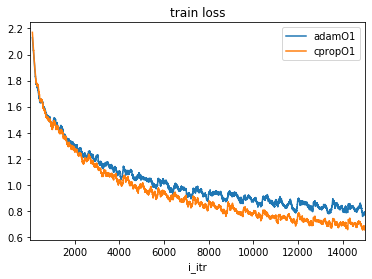

In [19]:
ax = plt.subplot()
ax.set_title('train loss')
for k, v in dfs2.items():
    if 'O1' in k:
        plot(v, 'loss', smooth=100, ax=ax, label=k)

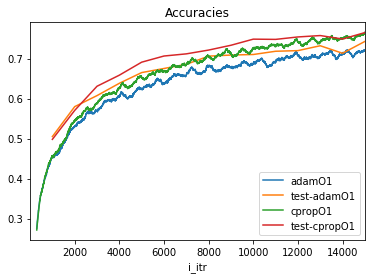

In [33]:
ax = plt.subplot()
ax.set_title('Accuracies')
for k, v in dfs2.items():
    if 'O1' in k:
        plot(v, 'acc', smooth=300, ax=ax, label=k)
        plot(v, 'test_acc', ax=ax, label=f'test-{k}')
plt.savefig('cifar10_small.png')

### Mixed precision O2

In [20]:
dfs2['adamO2'] = run(15000, 1e-3, use_cprob=False, apex=True, opt_level='O2')

  0%|          | 19/15000 [00:00<02:26, 102.10it/s, loss=2.25, acc=0.136]

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  1%|          | 174/15000 [00:01<02:23, 103.10it/s, loss=1.93, acc=0.271]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 15%|█▍        | 2181/15000 [00:24<02:06, 101.16it/s, loss=1.27, acc=0.521]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 28%|██▊       | 4192/15000 [00:47<01:49, 98.87it/s, loss=1.14, acc=0.602]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 28%|██▊       | 4235/15000 [00:47<01:46, 101.46it/s, loss=1.04, acc=0.624]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 53%|█████▎    | 7993/15000 [01:29<01:08, 102.88it/s, loss=1.01, acc=0.658] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 67%|██████▋   | 9999/15000 [01:51<00:48, 102.17it/s, loss=0.86, acc=0.693] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 81%|████████  | 12111/15000 [02:17<00:33, 85.34it/s, loss=0.897, acc=0.696] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 95%|█████████▍| 14241/15000 [02:41<00:07, 101.88it/s, loss=0.863, acc=0.701]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 15000/15000 [02:50<00:00, 88.15it/s, loss=0.734, acc=0.739] 


In [21]:
dfs2['cpropO2'] = run(15000, 1e-3, use_cprob=True, apex=True, opt_level='O2')

  0%|          | 18/15000 [00:00<02:35, 96.08it/s, loss=2.3, acc=0.102] 

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  1%|          | 168/15000 [00:01<02:36, 94.82it/s, loss=1.94, acc=0.26] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 15%|█▍        | 2182/15000 [00:25<02:13, 95.76it/s, loss=1.19, acc=0.571]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 21%|██        | 3170/15000 [00:37<02:04, 95.31it/s, loss=1.09, acc=0.63]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 41%|████▏     | 6191/15000 [01:14<01:31, 96.28it/s, loss=0.86, acc=0.692] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 55%|█████▍    | 8196/15000 [01:38<01:11, 94.73it/s, loss=0.809, acc=0.706]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 69%|██████▉   | 10389/15000 [02:04<00:47, 96.58it/s, loss=0.757, acc=0.73] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 86%|████████▌ | 12902/15000 [02:33<00:22, 95.21it/s, loss=0.729, acc=0.728]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|█████████▉| 14947/15000 [02:57<00:00, 94.94it/s, loss=0.628, acc=0.781]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 15000/15000 [03:00<00:00, 83.33it/s, loss=0.621, acc=0.785]


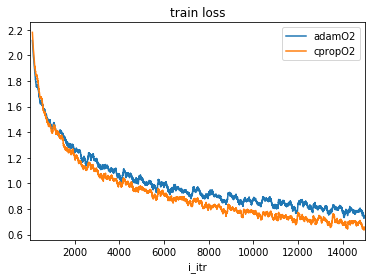

In [22]:
ax = plt.subplot()
ax.set_title('train loss')
for k, v in dfs2.items():
    if 'O2' in k:
        plot(v, 'loss', smooth=100, ax=ax, label=k)

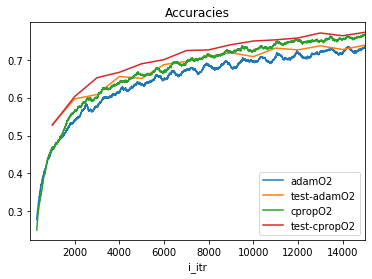

In [32]:
ax = plt.subplot()
ax.set_title('Accuracies')
for k, v in dfs2.items():
    if 'O2' in k:
        plot(v, 'acc', smooth=300, ax=ax, label=k)
        plot(v, 'test_acc', ax=ax, label=f'test-{k}')
plt.savefig('cifar10_small.png')

### Full FP16 O3

In [23]:
dfs2['adamO3'] = run(15000, 1e-3, use_cprob=False, apex=True, opt_level='O3')

  0%|          | 21/15000 [00:00<02:10, 114.87it/s, loss=3.59, acc=0.0994]

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


100%|██████████| 15000/15000 [02:35<00:00, 96.19it/s, loss=0.922, acc=0.669] 


In [24]:
dfs2['cpropO3'] = run(15000, 1e-3, use_cprob=True, apex=True, opt_level='O3')

  0%|          | 0/15000 [00:00<?, ?it/s]

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


100%|██████████| 15000/15000 [02:46<00:00, 90.18it/s, loss=0.758, acc=0.735] 


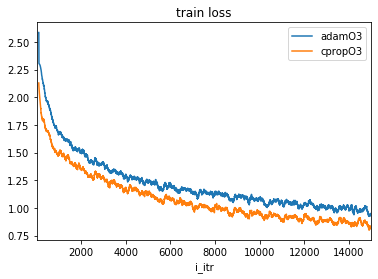

In [25]:
ax = plt.subplot()
ax.set_title('train loss')
for k, v in dfs2.items():
    if 'O3' in k:
        plot(v, 'loss', smooth=100, ax=ax, label=k)

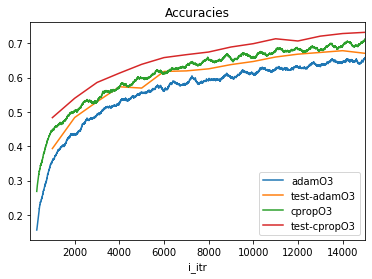

In [31]:
ax = plt.subplot()
ax.set_title('Accuracies')
for k, v in dfs2.items():
    if 'O3' in k:
        plot(v, 'acc', smooth=300, ax=ax, label=k)
        plot(v, 'test_acc', ax=ax, label=f'test-{k}')
plt.savefig('cifar10_small.png')